In [1]:
import numpy as np
import torch as nn


In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [11]:
from torch.utils.data import DataLoader

loaders = { 
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

}

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x=F.relu(F.max_pool2d(self.conv1(x),2 ))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x, training=self.training)
        x=self.fc2(x)

        return F.softmax(x)
    




In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model=CNN().to(device)

optimizer=optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 ==0:
            #print(f'Train epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}')
            print(f"Train epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")



In [23]:
def test():
    model.eval()
    test_loss=0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()

            pred= output.argmax(dim = 1, keepdim = True)
            correct+= pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\n Test set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({1000. *correct / len(loaders["test"].dataset):.0f}%\n)')

In [24]:
for epoch in range(1,11):
    train(epoch)
    test()

C:\Users\mukha\AppData\Local\Temp\ipykernel_28932\1969689584.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train epoch: 1 [0/60000 (0%)]	2.302645
Train epoch: 1 [2000/60000 (3%)]	2.289344
Train epoch: 1 [4000/60000 (7%)]	2.175595
Train epoch: 1 [6000/60000 (10%)]	2.014043
Train epoch: 1 [8000/60000 (13%)]	1.949718
Train epoch: 1 [10000/60000 (17%)]	1.837487
Train epoch: 1 [12000/60000 (20%)]	1.719165
Train epoch: 1 [14000/60000 (23%)]	1.790082
Train epoch: 1 [16000/60000 (27%)]	1.716530
Train epoch: 1 [18000/60000 (30%)]	1.693709
Train epoch: 1 [20000/60000 (33%)]	1.706974
Train epoch: 1 [22000/60000 (37%)]	1.670725
Train epoch: 1 [24000/60000 (40%)]	1.699229
Train epoch: 1 [26000/60000 (43%)]	1.739758
Train epoch: 1 [28000/60000 (47%)]	1.675916
Train epoch: 1 [30000/60000 (50%)]	1.587371
Train epoch: 1 [32000/60000 (53%)]	1.621095
Train epoch: 1 [34000/60000 (57%)]	1.627029
Train epoch: 1 [36000/60000 (60%)]	1.641435
Train epoch: 1 [38000/60000 (63%)]	1.608473
Train epoch: 1 [40000/60000 (67%)]	1.594854
Train epoch: 1 [42000/60000 (70%)]	1.639417
Train epoch: 1 [44000/60000 (73%)]	1.675707

In [27]:
device

device(type='cpu')

C:\Users\mukha\AppData\Local\Temp\ipykernel_28932\1969689584.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediciton:7


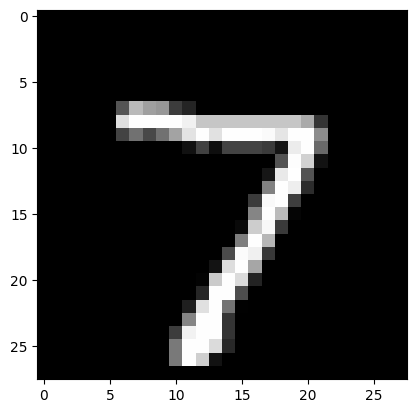

In [25]:
import matplotlib.pyplot as plt
model.eval()

data, target = test_data[0]
data = data.unsqueeze(0).to(device)

output= model(data)

prediction = output.argmax(dim= 1, keepdim = True).item()
print(f'Prediciton:{prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()
